<a href="https://colab.research.google.com/github/jasleenkaursandhu/Reproducing-chest-xray-report-generation-boag/blob/main/01_mimic_cxr_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries and mount google drive
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import tqdm
from collections import defaultdict
import pickle
import gzip
import random
import re
import warnings
!pip install pydicom

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_path = '/content/drive/MyDrive/mimic-cxr-project'
!mkdir -p {base_path}/data

Mounted at /content/drive


In [ ]:
# Load and preprocess data shapes
record_list_path = os.path.join(base_path, 'cxr-record-list.csv')
study_list_path = os.path.join(base_path, 'cxr-study-list.csv')

# Load the CSV files
df_studies = pd.read_csv(study_list_path)
df_records = pd.read_csv(record_list_path)

# Print the counts from these files
print('Images based on record list: %6d' % len(df_records))
print('Reports based on study list: %6d' % len(df_studies))

# Merge them to create a single dataframe with the columns we need
df = pd.merge(
    df_studies[['subject_id', 'study_id']],
    df_records[['subject_id', 'study_id', 'dicom_id']],
    on=['subject_id', 'study_id']
)

# Add dicom_is_available column
df['dicom_is_available'] = True

print(df.shape)
display(df.head())

print('unique subjects: %6d' % len(set(df['subject_id'])))
print('unique studies: %6d' % len(set(df['study_id'])))
print('unique   dicoms: %6d' % len(set(df['dicom_id'])))

Images based on record list: 377110
Reports based on study list: 227835
(377110, 4)


,subject_id,study_id,dicom_id,dicom_is_available
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,True
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,True
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,True
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,True
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,True


unique subjects:  65379
unique studies: 227835
unique   dicoms: 377110


In [ ]:
# Implementing report parser
import re

class MIMIC_RE(object):
    def __init__(self):
        self._cached = {}

    def get(self, pattern, flags=0):
        key = hash((pattern, flags))
        if key not in self._cached:
            self._cached[key] = re.compile(pattern, flags=flags)

        return self._cached[key]

    def sub(self, pattern, repl, string, flags=0):
        return self.get(pattern, flags=flags).sub(repl, string)

    def rm(self, pattern, string, flags=0):
        return self.sub(pattern, '', string)

    def get_id(self, tag, flags=0):
        return self.get(r'\[\*\*.*{:s}.*?\*\*\]'.format(tag), flags=flags)

    def sub_id(self, tag, repl, string, flags=0):
        return self.get_id(tag).sub(repl, string)

def parse_report(path):
    mimic_re = MIMIC_RE()
    with open(path,'r') as f:
        report = f.read()
    report = report.lower()
    report = mimic_re.sub_id(r'(?:location|address|university|country|state|unit number)', 'LOC', report)
    report = mimic_re.sub_id(r'(?:year|month|day|date)', 'DATE', report)
    report = mimic_re.sub_id(r'(?:hospital)', 'HOSPITAL', report)
    report = mimic_re.sub_id(r'(?:identifier|serial number|medical record number|social security number|md number)', 'ID', report)
    report = mimic_re.sub_id(r'(?:age)', 'AGE', report)
    report = mimic_re.sub_id(r'(?:phone|pager number|contact info|provider number)', 'PHONE', report)
    report = mimic_re.sub_id(r'(?:name|initial|dictator|attending)', 'NAME', report)
    report = mimic_re.sub_id(r'(?:company)', 'COMPANY', report)
    report = mimic_re.sub_id(r'(?:clip number)', 'CLIP_NUM', report)

    report = mimic_re.sub((
        r'\[\*\*(?:'
            r'\d{4}'  # 1970
            r'|\d{0,2}[/-]\d{0,2}'  # 01-01
            r'|\d{0,2}[/-]\d{4}'  # 01-1970
            r'|\d{0,2}[/-]\d{0,2}[/-]\d{4}'  # 01-01-1970
            r'|\d{4}[/-]\d{0,2}[/-]\d{0,2}'  # 1970-01-01
        r')\*\*\]'
    ), 'DATE', report)
    report = mimic_re.sub(r'\[\*\*.*\*\*\]', 'OTHER', report)
    report = mimic_re.sub(r'(?:\d{1,2}:\d{2})', 'TIME', report)

    report = mimic_re.rm(r'_{2,}', report, flags=re.MULTILINE)
    report = mimic_re.rm(r'the study and the report were reviewed by the staff radiologist.', report)


    matches = list(mimic_re.get(r'^(?P<title>[ \w()]+):', flags=re.MULTILINE).finditer(report))
    parsed_report = {}
    for (match, next_match) in zip(matches, matches[1:] + [None]):
        start = match.end()
        end = next_match and next_match.start()

        title = match.group('title')
        title = title.strip()

        paragraph = report[start:end]
        paragraph = mimic_re.sub(r'\s{2,}', ' ', paragraph)
        paragraph = paragraph.strip()

        parsed_report[title] = paragraph.replace('\n', '\\n')

    return parsed_report

In [ ]:
# Extracting view positions
import pydicom
import gzip
import tqdm

# Initialize positions dictionary
positions = {}

# Get column names
columns = df.columns

# Process all rows in the dataframe - using the full dataset
for vals in tqdm.tqdm(df.values):
    row = dict(zip(columns, vals))
    dicom_file = str(row['dicom_id']) + '.dcm'

    # Construct paths based on your file structure
    subject_id = row['subject_id']
    subject_prefix = f"p{str(subject_id)[:2]}"
    subject_dir = f"p{subject_id}"
    study_id = row['study_id']
    study_dir = f"s{study_id}"

    # Full path to the DICOM file
    dicom_path = os.path.join(base_path, 'files', subject_prefix, subject_dir, study_dir, dicom_file)

    # Check if file exists
    if os.path.exists(dicom_path):
        try:
            plan = pydicom.dcmread(dicom_path, stop_before_pixels=True)
            if hasattr(plan, 'ViewPosition'):
                view_position = plan.ViewPosition
                positions[row['dicom_id']] = view_position
        except Exception as e:
            # Just continue without printing errors to avoid cluttering output
            pass

# Save view positions
view_positions_path = os.path.join(base_path, 'view_positions.pkl')
with open(view_positions_path, 'wb') as f:
    pickle.dump(positions, f)

print(f"Extracted view positions for {len(positions)} images")

# View position distribution
position_counts = pd.Series(positions.values()).value_counts()
print("\nView position distribution:")
print(position_counts)

100%|██████████| 377110/377110 [3:13:52<00:00, 32.42it/s]  


Extracted view positions for 3242 images

View position distribution:
AP         3174
PA           19
             18
LATERAL      17
LL           14
Name: count, dtype: int64


In [ ]:
# Load the view positions we saved earlier
view_positions_path = os.path.join(base_path, 'view_positions.pkl')
with open(view_positions_path, 'rb') as f:
    view_positions = pickle.load(f)

print(f"Loaded {len(view_positions)} view positions")
print("Sample view positions:", dict(list(view_positions.items())[:2]))

Loaded 3242 view positions
Sample view positions: {'68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714': 'AP', 'fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818': 'AP'}


In [ ]:
# Build dataset of (image, report) pairs organized by patient
data = defaultdict(list)

# Process rows to find AP images with reports
columns = df.columns
for vals in tqdm.tqdm(df.values):
    row = dict(zip(columns, vals))

    # Construct paths
    subject_id = row['subject_id']
    subject_prefix = f"p{str(subject_id)[:2]}"
    subject_dir = f"p{subject_id}"
    study_id = row['study_id']
    study_dir = f"s{study_id}"

    dicom_file = f"{row['dicom_id']}.dcm"
    dicom_path = os.path.join(base_path, 'files', subject_prefix, subject_dir, study_dir, dicom_file)

    report_file = f"{study_dir}.txt"
    report_path = os.path.join(base_path, 'files', subject_prefix, subject_dir, report_file)

    # Check if files exist
    if not os.path.exists(dicom_path) or not os.path.exists(report_path):
        continue

    # Only AP images
    dicom_id = row['dicom_id']
    if dicom_id not in view_positions or view_positions[dicom_id] != 'AP':
        continue

    # Check if report has findings section
    try:
        with open(report_path, 'r') as f:
            report_text = f.read().lower()
        if 'findings' in report_text:
            item = (dicom_path, report_path)
            data[row['subject_id']].append(item)
    except Exception as e:
        pass

print(f"Built dataset with {len(data)} patients")
print(f"Total image-report pairs: {sum(len(items) for items in data.values())}")

100%|██████████| 377110/377110 [19:02<00:00, 330.22it/s] 

Built dataset with 649 patients
Total image-report pairs: 1206


In [ ]:
# List of unique dicom IDs
dicom_ids = set()
for subject_id, items in list(data.items()):
    for dicom_path, report_path in items:
        dicom_id = os.path.basename(dicom_path).split('.')[0]
        dicom_ids.add(dicom_id)

print(f"Found {len(dicom_ids)} unique DICOM IDs")

Found 1206 unique DICOM IDs


In [ ]:
# List of subject IDs
subject_ids = list(data.keys())

# Create train/test split
subject_ids = list(subject_ids)  # Create a copy
random.shuffle(subject_ids)  # Shuffle randomly

n = len(subject_ids)
split_ind = int(0.7 * n)  # 70% training, 30% testing
train_ids = subject_ids[:split_ind]
test_ids = subject_ids[split_ind:]

print('Train subjects:', len(train_ids))
print('Test subjects:', len(test_ids))

Train subjects: 454
Test subjects: 195


In [ ]:
# Check how many images are in each split
train_images = 0
test_images = 0

for subject_id in train_ids:
    train_images += len(data[subject_id])

for subject_id in test_ids:
    test_images += len(data[subject_id])

print(f"Train images: {train_images}")
print(f"Test images: {test_images}")
print(f"Total images: {train_images + test_images}")

Train images: 824
Test images: 382
Total images: 1206


In [ ]:
# Create dataframes for train/test sets
train_rows = []
for subject_id in train_ids:
    for dicom_path, report_path in data[subject_id]:
        dicom_id = os.path.basename(dicom_path).split('.')[0]
        study_id = os.path.basename(os.path.dirname(dicom_path))
        train_rows.append({
            'subject_id': subject_id,
            'study_id': study_id.replace('s', ''),  # Remove the 's' prefix
            'dicom_id': dicom_id
        })

test_rows = []
for subject_id in test_ids:
    for dicom_path, report_path in data[subject_id]:
        dicom_id = os.path.basename(dicom_path).split('.')[0]
        study_id = os.path.basename(os.path.dirname(dicom_path))
        test_rows.append({
            'subject_id': subject_id,
            'study_id': study_id.replace('s', ''),  # Remove the 's' prefix
            'dicom_id': dicom_id
        })

train_df = pd.DataFrame(train_rows)
test_df = pd.DataFrame(test_rows)

# Write to file
train_df.to_csv(os.path.join(base_path, 'data', 'train.tsv'), sep='\t', index=False)
test_df.to_csv(os.path.join(base_path, 'data', 'test.tsv'), sep='\t', index=False)

print(f"Saved {len(train_df)} training samples to data/train.tsv")
print(f"Saved {len(test_df)} test samples to data/test.tsv")

Saved 824 training samples to data/train.tsv
Saved 382 test samples to data/test.tsv


10000032 (2)
	-----------
	Patient ID: 10000032
	View Position: AP


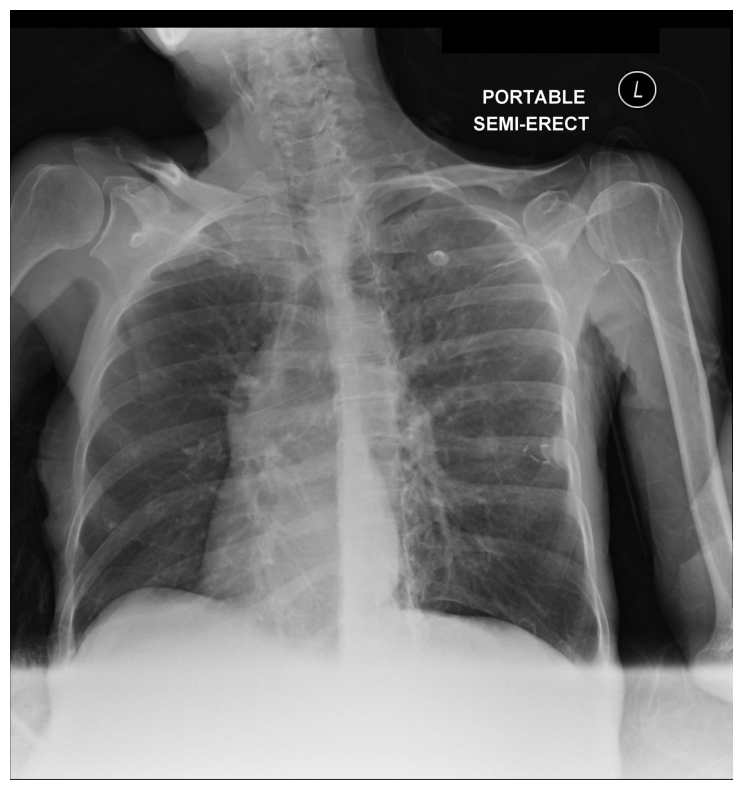

	Findings: single frontal view of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. no free air below the right hemidiaphragm is seen.
	-----------
	Patient ID: 10000032
	View Position: AP


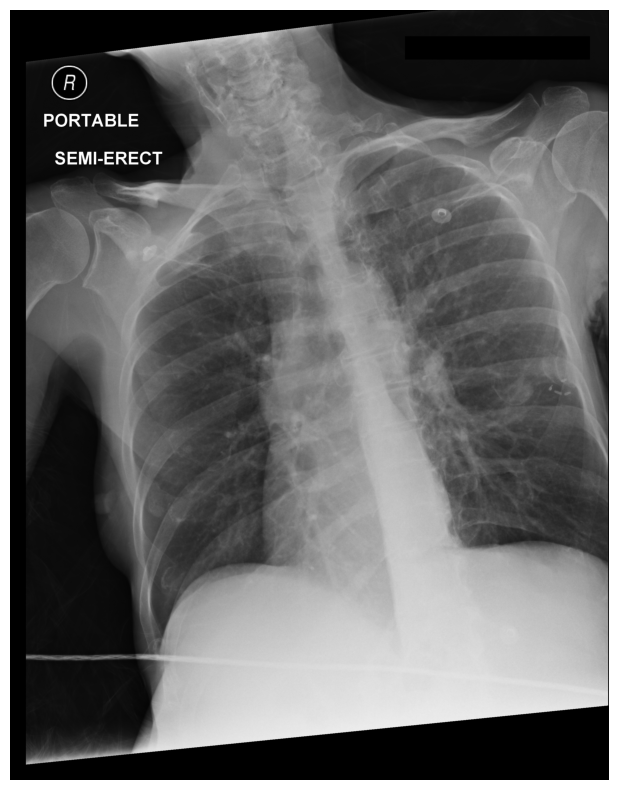

	Findings: single frontal view of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. no free air below the right hemidiaphragm is seen.

10005024 (1)
	-----------
	Patient ID: 10005024
	View Position: AP


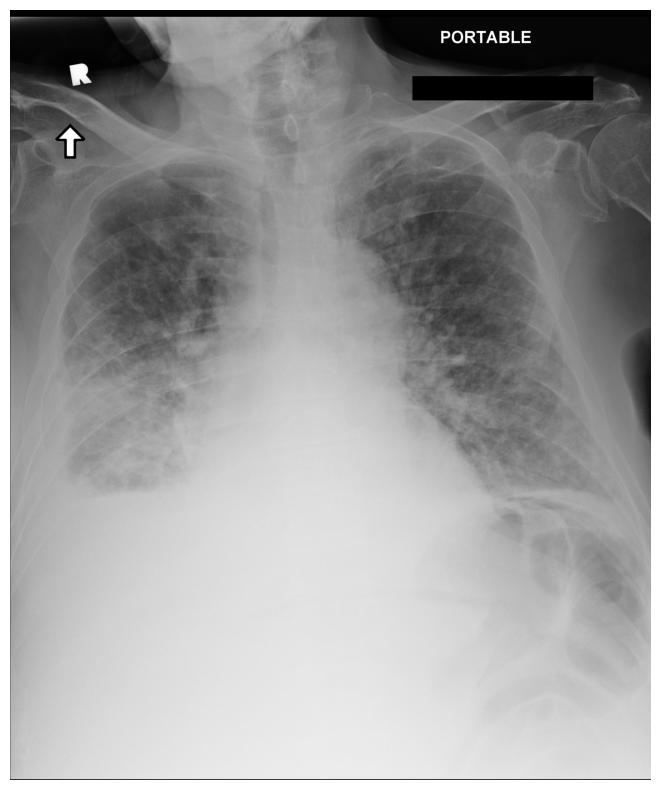

	Findings: numerous nodular opacities compatible the patient's metastatic disease are again appreciated. in addition, there is worsening pulmonary edema as well as a worsening right lower lobe infiltrate which could represent pneumonia in the correct clinical setting. a right pleural effusion is also increased in size.

10011365 (1)
	-----------
	Patient ID: 10011365
	View Position: AP


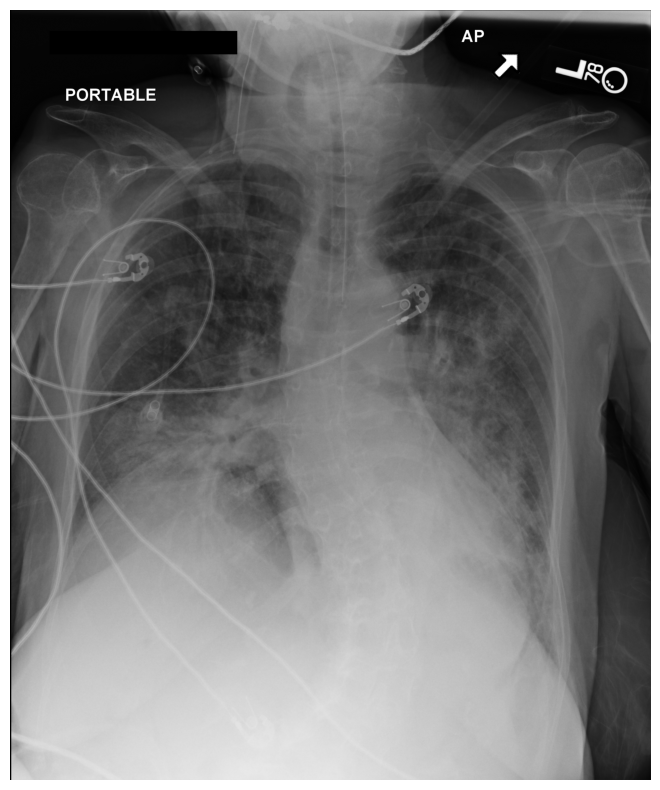

	Findings: endotracheal tube tip is now 2.5 cm above carina, has been pulled back since prior. significant interval worsening of bilateral perihilar, lower lung opacities, with bronchovascular distribution, consider worsening pneumonia, aspiration or edema. elevated right hemidiaphragm stable. borderline heart size. thoracolumbar curve.



In [ ]:
# Load a few images to spot check
n = min(3, len(data))
first_n = dict(list(data.items())[:n])

for subject_id, items in first_n.items():
    print(f'{subject_id} ({len(items)})')

    for j, (dicom_path, report_path) in enumerate(items[:2]):  # Show up to 2 images per patient
        try:
            # Read DICOM file
            plan = pydicom.dcmread(dicom_path)

            # Convert to image
            pixel_array = plan.pixel_array
            image = Image.fromarray(np.uint8(pixel_array/pixel_array.max()*255))

            # Parse report
            parsed_report = parse_report(report_path)

            # Display information
            print('\t-----------')
            print('\tPatient ID:', plan.PatientID if hasattr(plan, 'PatientID') else 'Unknown')
            print('\tView Position:', plan.ViewPosition if hasattr(plan, 'ViewPosition') else 'Unknown')

            plt.figure(figsize=(10, 10))
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.show()

            if 'findings' in parsed_report:
                print("\tFindings:", parsed_report['findings'])
            else:
                print('\tFindings: None')

        except Exception as e:
            print(f"\tError processing {dicom_path}: {e}")

    print('\t===================================================')
    print()

In [33]:
# Random Baseline Implementation
print("Implementing Random Baseline Model")

# Train/test data should already be available from previous cells
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Map each dicom to its corresponding report identifier
# Adjust column names based on your data structure
report_id_column = 'study_id'  # This might be 'rad_id' or 'study_id' depending on your data
if report_id_column in train_df.columns:
    report_lookup = dict(train_df[['dicom_id', report_id_column]].values)
    print(f"Created lookup using {report_id_column}")
else:
    print(f"Warning: {report_id_column} not found in columns: {train_df.columns.tolist()}")
    report_lookup = {}

print("Sample of lookup dictionary:")
print(dict(list(report_lookup.items())[:5]))

# Generate random reports for each test image
generated_reports = {}

for pred_dicom in tqdm.tqdm(test_df.dicom_id.values):
    found = False
    attempts = 0
    max_attempts = 100  # Limit attempts to avoid infinite loops

    while not found and attempts < max_attempts:
        attempts += 1

        # Randomly select a training image
        nearest_dicom = random.choice(train_df.dicom_id.values)

        if nearest_dicom not in report_lookup:
            continue

        report_id = report_lookup[nearest_dicom]

        # Get corresponding subject_id
        subject_row = train_df[train_df.dicom_id == nearest_dicom]
        if len(subject_row) == 0:
            continue

        subject_id = subject_row.iloc[0]['subject_id']

        # Construct path to the report
        subject_prefix = f"p{str(subject_id)[:2]}"
        subject_dir = f"p{subject_id}"
        study_dir = f"s{report_id}"
        report_file = f"{study_dir}.txt"
        report_path = os.path.join(files_path, subject_prefix, subject_dir, report_file)

        # Parse the report to extract sections
        try:
            if os.path.exists(report_path):
                report = parse_report(report_path)

                # If the report has a findings section, use it
                if 'findings' in report:
                    found = True
                    generated_reports[pred_dicom] = report['findings']
        except Exception as e:
            # Skip this report and try another
            continue

    if not found:
        print(f"Warning: Could not find a valid report for {pred_dicom} after {max_attempts} attempts")

print(f"Generated random reports for {len(generated_reports)}/{len(test_df)} test images")

# Create output directory if it doesn't exist
pred_dir = os.path.join(base_path, 'output')
os.makedirs(pred_dir, exist_ok=True)

# Save the generated reports to a TSV file
pred_file = os.path.join(pred_dir, 'random.tsv')
print(f"Saving predictions to {pred_file}")

with open(pred_file, 'w') as f:
    print('dicom_id\tgenerated', file=f)
    for dicom_id, generated in sorted(generated_reports.items()):
        # Escape any tab characters in the generated text
        cleaned_text = generated.replace('\t', ' ')
        print(f'{dicom_id}\t{cleaned_text}', file=f)

print(f"Saved random baseline predictions to {pred_file}")
print(f"Current time: {strftime('%Y-%m-%d %H:%M:%S', gmtime())}")

Implementing Random Baseline Model...
Train data shape: (824, 3)
Test data shape: (382, 3)
Created lookup using study_id
Sample of lookup dictionary:
{'dfd9a06c-2994892e-f4a6bc1c-f6ec4803-283e5005': '55606773', 'ab50de59-ebf1d4df-20709b76-e8df1c5b-02561a38': '55244750', 'fafaee95-e11d24c5-ad39cfcd-302ac853-4a6f16ac': '58401243', 'fd53f5b0-0070f205-6c47cbe6-eaf7140d-12b09066': '57100718', '78e28f8c-fc928714-2cdc13f2-e6e45d40-89cb7eca': '53346921'}


100%|██████████| 382/382 [00:05<00:00, 73.66it/s]


Generated random reports for 382/382 test images
Saving predictions to /content/drive/MyDrive/mimic-cxr-project/output/random.tsv
Saved random baseline predictions to /content/drive/MyDrive/mimic-cxr-project/output/random.tsv
Current time: 2025-04-06 01:57:47
